In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from geopy.distance import geodesic as GD
from collections import Counter
import math
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.path as mpath
from scipy.stats import gaussian_kde
from matplotlib import cm
import pandas as pd
import matplotlib as mpl
from datetime import datetime, timedelta
import xarray as xr
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
import random
from matplotlib.patches import FancyArrow
plt.rcParams['font.family'] = 'Times New Roman'

# A

In [2]:
data_address = '../../data/Network1/EvSy_real.h5'

f = h5py.File(data_address,'r')
events = f['events'][:]
lat = f['lat'][:]
lon = f['lon'][:]
f.close()

C:\Users\34322\AppData\Local\Temp\ipykernel_30164\215084072.py:23: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x000001CF02D3F3D0>' will be ignored
  c1.set_rasterized(True)


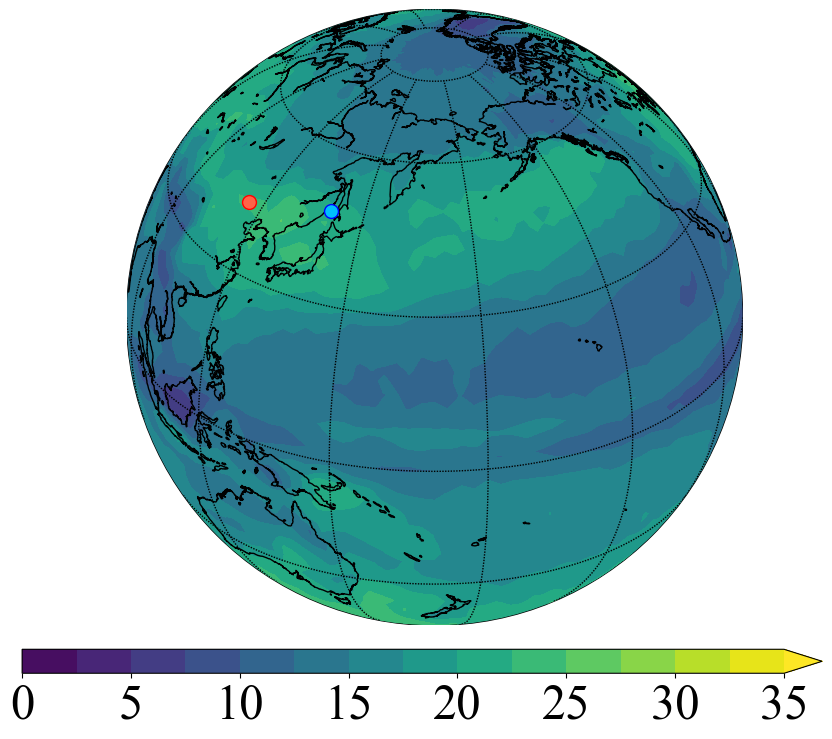

In [5]:
cyclic_data,cyclic_lon = add_cyclic_point(events,coord=lon)

fig = plt.figure(figsize=(10,8))
m = Basemap(projection='nsper',lon_0=170,lat_0=30,
        satellite_height=10000000000.,resolution='l')
m.drawcoastlines(linewidth=1)
m.drawparallels(np.arange(-90.,90.,30.))
m.drawmeridians(np.arange(-180.,180.,30.))

mlon, mlat = np.meshgrid(cyclic_lon, lat)
x, y = m(mlon, mlat)

x1, y1 = m(115,42.5)
x2, y2 = m(140,47.5)

c1 = m.contourf(x,y,cyclic_data/43,cmap=cm.viridis,levels =np.linspace(0,35,15),extend = 'max')
m.plot(x1, y1, marker='.', color='tomato', markersize=20,markeredgecolor='red', markeredgewidth=1)
m.plot(x2, y2, marker='.', color='deepskyblue', markersize=20,markeredgecolor='blue', markeredgewidth=1)

colorbar = fig.add_axes([0.1,0.05,0.8,0.03])
cbar = fig.colorbar(c1,cax=colorbar,orientation='horizontal',format = '%d') 
cbar.ax.tick_params(labelsize=35)
c1.set_rasterized(True)
plt.savefig("FIG/FIG1/FIG1a.svg", bbox_inches='tight', dpi=400, transparent=True)



# B

In [6]:
data_address = '../../data/RAW_DATA/M2I3NXGAS_AOD_remove_leapyear.h5'

f = h5py.File(data_address,'r')
data = f['Global'][:]
data_lat = f['lat'][:]
data_lon = f['lon'][:]
f.close()

def get_time (data_array):

    date = np.zeros((len(data_array),))
    threshold = np.percentile(data_array,90)
    date[data_array>threshold] = 1

    tmp = date[1:] + date[:-1]
    if date[0] == 0:
        tmp = np.insert(tmp,0,0)
    else:
        tmp = np.insert(tmp,0,1)

    loc = np.arange(len(data_array))
    tmp_1 = loc[tmp == 1]

    events_time = []
    for k in range (0,len(tmp_1),2):
        time_tmp = tmp_1[k]
        events_time.append(time_tmp)
    
    return(np.array(events_time))


def EvSy(i,j,k):

    timestamp_array1 = i
    timestamp_array2 = j
    
    event1= len(timestamp_array1)
    event2= len(timestamp_array2)

    EvSy_i_ts = []
    EvSy_j_ts = []


    for i in range (1,(event1-1)):
        for j in range (1,(event2-1)):
            delay = (min (timestamp_array1[i+1]-timestamp_array1[i],timestamp_array1[i]-timestamp_array1[i-1],timestamp_array2[j+1]-timestamp_array2[j],timestamp_array2[j]-timestamp_array2[j-1]))/2
                    
            waiting_time = timestamp_array1[i] - timestamp_array2[j]

            if abs(waiting_time) <= delay and abs(waiting_time) <= k :
                EvSy_i_ts.append(timestamp_array1[i])
                EvSy_j_ts.append(timestamp_array2[j])

    return(EvSy_i_ts ,EvSy_j_ts)

def get_date_from_position(position):
    start_datetime = datetime.strptime('1980-01-01', '%Y-%m-%d')
    target_date = start_datetime + timedelta(days=int(position) - 1)
    return target_date.strftime('%Y-%m-%d')

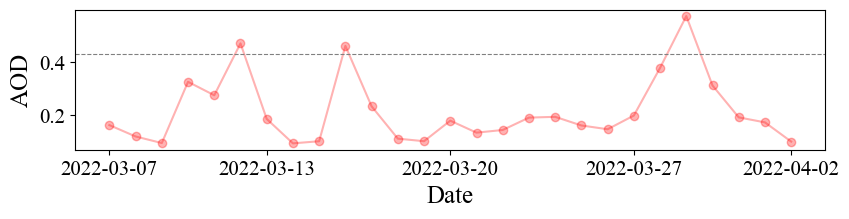

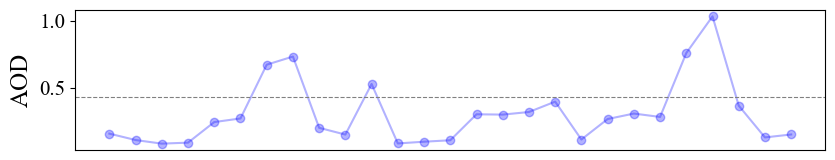

In [8]:
m = np.argmax(data_lat == 42.5)
n = np.argmax(data_lon == 115)
p = np.argmax(data_lat == 47.5)
q = np.argmax(data_lon == 140)

i_ts = get_time(np.reshape(data[...,m,n],-1))
j_ts = get_time(np.reshape(data[...,p,q],-1))

EvSy_i_ts,EvSy_j_ts =EvSy(i_ts,j_ts,30)

random_ts= random.randint(0,len(EvSy_i_ts))

#i_ts_index = np.where(i_ts == EvSy_i_ts[random_ts])[0]
#j_ts_index = np.where(j_ts == EvSy_j_ts[random_ts])[0]

i_ts_index = np.array([994])
j_ts_index = np.array([915])

data_max = max(i_ts[i_ts_index+1],j_ts[j_ts_index+1])[0]+5
data_min = min(i_ts[i_ts_index-1],j_ts[j_ts_index-1])[0]-5

thresholdi = np.percentile(np.reshape(data[...,m,n],-1),90)
thresholdj = np.percentile(np.reshape(data[...,p,q],-1),90)

AOD_i = np.reshape(data[...,m,n],-1)[data_min:data_max]
AOD_j = np.reshape(data[...,p,q],-1)[data_min:data_max]

time_array = np.array(range(data_min,data_max,1))
x = range(0,data_max-data_min,1)
data_list = []
for i in range(0,len(time_array),1):
    data_list.append(get_date_from_position(time_array[i]))

xticks = [0,len(x)//4,len(x)//2,len(x)*3//4,len(x)-1]
custom_labels = [data_list[0],data_list[len(x)//4],data_list[len(x)//2],data_list[len(x)*3//4],data_list[len(x)-1]]

plt.rcParams['font.family'] = 'Times New Roman'

fig = plt.figure(figsize=(15,3.5))
ax1 = fig.add_axes([0.1,0.1,0.5,0.4])

ax1.plot(x,AOD_i,color = 'red',alpha=0.3)
ax1.scatter(x,AOD_i,color = 'red',alpha=0.3)
ax1.axhline(thresholdi ,ls = '--',c = 'gray',linewidth=0.8)
plt.tick_params(axis='both', labelsize=15)
plt.xticks(xticks,custom_labels)
plt.xlabel('Date',fontsize=18)
plt.ylabel('AOD',fontsize=18)
plt.savefig("FIG/FIG1/FIG1b1.svg", bbox_inches='tight', dpi=400, transparent=True)
#fig.savefig('../image/os1.svg',dpi = 750,bbox_inches='tight') 
plt.show()


fig = plt.figure(figsize=(15,3.5))
ax1 = fig.add_axes([0.1,0.1,0.5,0.4])

ax1.plot(x,AOD_j,color = 'blue',alpha=0.3)
ax1.scatter(x,AOD_j,color = 'blue',alpha=0.3)
ax1.axhline(thresholdj ,ls = '--',c = 'gray',linewidth=0.8)
plt.tick_params(axis='both', labelsize=15)
ax1.get_xaxis().set_visible(False)
#plt.xticks(xticks,custom_labels)
#plt.xlabel('Date',fontsize=15)
plt.ylabel('AOD',fontsize=18)
#ax1.xaxis.set_ticks_position('top')
#ax1.xaxis.set_label_position('top')
plt.savefig("FIG/FIG1/FIG1b2.svg", bbox_inches='tight', dpi=400, transparent=True)

plt.show()

# E

In [16]:
absolute_address = '../..'

Network1_address = absolute_address + '/data/Each_SC_threshold_result/Network1_SC.h5'
f_Network1 = h5py.File(Network1_address,'r')
SC = f_Network1['SC'][:]
asy = f_Network1['asy'][:]
dis = f_Network1['dis'][:]
asy = f_Network1['asy'][:]
lat = f_Network1['lat'][:]
lon = f_Network1['lon'][:]
f_Network1.close()

asy_threshold_address = absolute_address + '/data/Each_SC_threshold_result/asy_threshold.h5'
f_asy_threshold = h5py.File(asy_threshold_address,'r')
asy_threshold = f_asy_threshold['asy_threshold'][()]
f_asy_threshold.close()

In [17]:
with open('../../data/RAW_DATA/latlon726.txt', 'r', encoding='utf-8') as file:
    lon_726 = []
    lat_726 = []

    for line in file:
        col1, col2 = map(float, line.strip().split())
        lon_726.append(col1)
        lat_726.append(col2)

    lon_726 = np.array(lon_726)
    lat_726 = np.array(lat_726)

    for i in range (len(lon_726)):
        if 0 <= lon_726[i] <= 180:
            continue
        else:
            lon_726[i] = lon_726[i] - 360

In [18]:
lat_726_location,lon_762_location = [],[]

for i in range (len(lon_726)):
    m = np.argmax(lat == lat_726[i])
    n = np.argmax(lon == lon_726[i])

    lat_726_location.append(m)
    lon_762_location.append(n)

lat_726_location = np.array(lat_726_location)
lon_762_location = np.array(lon_762_location)

In [19]:
trans_lat_start,trans_lon_start,trans_lat_end,trans_lon_end = [],[],[],[]

for i in range (len(lat_726_location)):
    for j in range (i,len(lon_762_location),1):
        if SC[lat_726_location[i],lon_762_location[i],lat_726_location[j],lon_762_location[j]] == 0:
            continue
        else:
            distance = dis[lat_726_location[i],lon_762_location[i],lat_726_location[j],lon_762_location[j]]
            if distance < 4000 and distance > 0:
                asy_temp = asy[lat_726_location[i],lon_762_location[i],lat_726_location[j],lon_762_location[j]]
                if abs(asy_temp) > asy_threshold:
                    trans_lat_start.append(lat[lat_726_location[i]])
                    trans_lon_start.append(lon[lon_762_location[i]])
                    trans_lat_end.append(lat[lat_726_location[j]])
                    trans_lon_end.append(lon[lon_762_location[j]])
                else:
                    continue
            else:
                continue

In [20]:
trans_lat_start_sy,trans_lon_start_sy,trans_lat_end_sy,trans_lon_end_sy = [],[],[],[]

for i in range (len(lat_726_location)):
    for j in range (i,len(lon_762_location),1):
        if SC[lat_726_location[i],lon_762_location[i],lat_726_location[j],lon_762_location[j]] == 0:
            continue
        else:
            distance = dis[lat_726_location[i],lon_762_location[i],lat_726_location[j],lon_762_location[j]]
            if distance < 4000 and distance > 0:
                asy_temp = asy[lat_726_location[i],lon_762_location[i],lat_726_location[j],lon_762_location[j]]
                if abs(asy_temp) <= asy_threshold:
                    trans_lat_start_sy.append(lat[lat_726_location[i]])
                    trans_lon_start_sy.append(lon[lon_762_location[i]])
                    trans_lat_end_sy.append(lat[lat_726_location[j]])
                    trans_lon_end_sy.append(lon[lon_762_location[j]])
                else:
                    continue
            else:
                continue

d:\miniconda\envs\py311\Lib\site-packages\numpy\lib\function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
C:\Users\34322\AppData\Local\Temp\ipykernel_30164\3623605051.py:40: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x000001CF04055390>' will be ignored
  c1.set_rasterized(True)


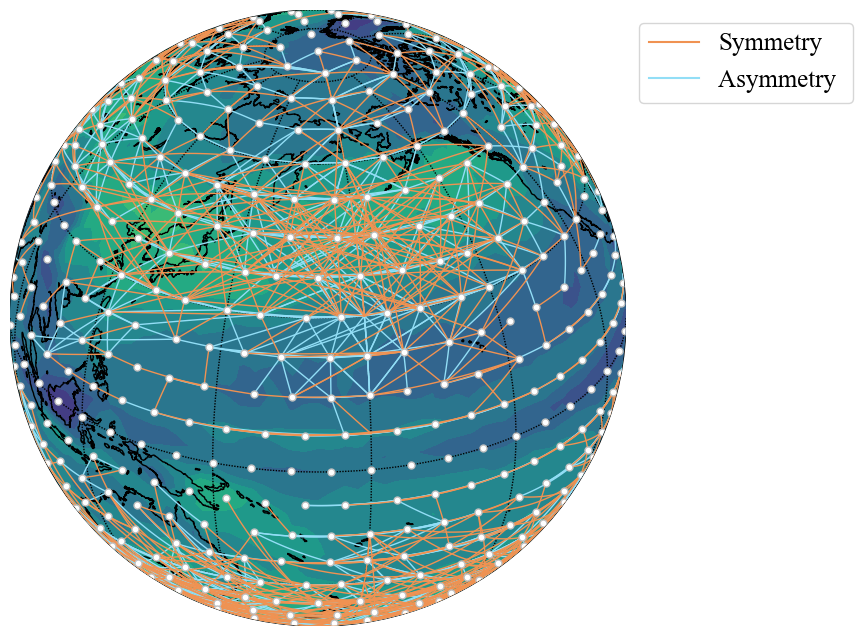

In [21]:
cyclic_data,cyclic_lon = add_cyclic_point(events,coord=lon)

fig = plt.figure(figsize=(10,8))
m = Basemap(projection='nsper',lon_0=170,lat_0=30,
        satellite_height=1000000000000.,resolution='l')
m.drawcoastlines(linewidth=1)
m.drawparallels(np.arange(-90.,90.,30.))
m.drawmeridians(np.arange(-180.,180.,30.))

    
for i in range (0,len(trans_lon_start)):
    m.drawgreatcircle(trans_lon_start[i],trans_lat_start[i],trans_lon_end[i],trans_lat_end[i],
                      linewidth=1,color='#92DEF6')

for i in range (0,len(trans_lat_start_sy),4):
    m.drawgreatcircle(trans_lon_start_sy[i],trans_lat_start_sy[i],trans_lon_end_sy[i],trans_lat_end_sy[i],
                      linewidth=1,color='#F09252')

legend_elements = [
    Line2D([0], [0], color='#F09252', lw=1.5, label='Symmetry'),
    Line2D([0], [0], color='#92DEF6', lw=1.5, label='Asymmetry ')
]
plt.legend(
    handles=legend_elements, 
    loc='upper left',      
    fontsize=18, 
    bbox_to_anchor=(1, 1),    
    borderaxespad=0.5          
)

mlon, mlat = np.meshgrid(cyclic_lon, lat)
x, y = m(mlon, mlat)

c1 = m.contourf(x,y,cyclic_data/43,cmap=cm.viridis,levels =np.linspace(0,35,15),extend = 'max')

for i in range (len(lon_726)):
    x, y = m(lon_726[i], lat_726[i])
    m.plot(x, y, marker='.', color='white', markersize=10,markeredgecolor='silver', markeredgewidth=1)

c1.set_rasterized(True)

plt.savefig("FIG/FIG1/FIG1e.svg", bbox_inches='tight', dpi=400, transparent=True)

#plt.savefig('test.png',dpi=500, bbox_inches='tight')

# D

In [14]:
#---------------------------------------------------------------------------------------------------

AOD_address =  '../../data/RAW_DATA/M2I3NXGAS_AOD_remove_leapyear.h5'
f_AOD = h5py.File(AOD_address,'r')
AOD_data = f_AOD['Global'][:]
AOD_lat = f_AOD['lat'][:]
AOD_lon = f_AOD['lon'][:]
f_AOD.close()

#---------------------------------------------------------------------------------------------------

def get_time (data_array):

    date = np.zeros((len(data_array),))
    threshold = np.percentile(data_array,90)
    date[data_array>threshold] = 1

    tmp = date[1:] + date[:-1]
    if date[0] == 0:
        tmp = np.insert(tmp,0,0)
    else:
        tmp = np.insert(tmp,0,1)

    loc = np.arange(len(data_array))
    tmp_1 = loc[tmp == 1]

    events_time = []
    for k in range (0,len(tmp_1),2):
        time_tmp = tmp_1[k]
        events_time.append(time_tmp)
    
    return(np.array(events_time))

def EvSy(i,j,k):

    timestamp_array1 = i
    timestamp_array2 = j
    
    event1= len(timestamp_array1)
    event2= len(timestamp_array2)

    EvSy_ij_i = []
    EvSy_ij_j = []

    EvSy_ji_i = []
    EvSy_ji_j = []

    for i in range (1,(event1-1)):
        for j in range (1,(event2-1)):
            delay = (min (timestamp_array1[i+1]-timestamp_array1[i],timestamp_array1[i]-timestamp_array1[i-1],timestamp_array2[j+1]-timestamp_array2[j],timestamp_array2[j]-timestamp_array2[j-1]))/2
                    
            waiting_time = timestamp_array1[i] - timestamp_array2[j]

            if -delay < waiting_time and waiting_time <= 0 and abs(waiting_time) <= k:
                EvSy_ij_i.append(timestamp_array1[i])
                EvSy_ij_j.append(timestamp_array2[j])
            if 0 <= waiting_time and waiting_time < delay and abs(waiting_time) <= k:
                EvSy_ji_i.append(timestamp_array1[i])
                EvSy_ji_j.append(timestamp_array2[j])

    return(EvSy_ij_i,EvSy_ij_j,EvSy_ji_i,EvSy_ji_j)

#-------------------------------------------------------------------------------------------------

def waiting_time(lat1,lon1,lat2,lon2):

    m = np.argmax(AOD_lat == lat1)
    n = np.argmax(AOD_lon == lon1)
    p = np.argmax(AOD_lat == lat2)
    q = np.argmax(AOD_lon == lon2)

    EvSy_ij_i =EvSy(get_time(np.reshape(AOD_data[...,m,n],-1)),get_time(np.reshape(AOD_data[...,p,q],-1)),30)[0]
    EvSy_ij_j =EvSy(get_time(np.reshape(AOD_data[...,m,n],-1)),get_time(np.reshape(AOD_data[...,p,q],-1)),30)[1]
    EvSy_ji_i =EvSy(get_time(np.reshape(AOD_data[...,m,n],-1)),get_time(np.reshape(AOD_data[...,p,q],-1)),30)[2]
    EvSy_ji_j =EvSy(get_time(np.reshape(AOD_data[...,m,n],-1)),get_time(np.reshape(AOD_data[...,p,q],-1)),30)[3]

    EvSy_ij_waiting_time = np.array(EvSy_ij_i) - np.array(EvSy_ij_j)
    EvSy_ji_waiting_time = np.array(EvSy_ji_i) - np.array(EvSy_ji_j)

    all_waiting_time = np.concatenate((EvSy_ij_waiting_time, EvSy_ji_waiting_time))

    latitude_label1 = "{:.1f}°{}".format(abs(lat1), "N" if lat1 >= 0 else "S")
    longitude_label1 = "{:.1f}°{}".format(abs(lon1), "E" if lon1 >= 0 else "W")
    latitude_label2 = "{:.1f}°{}".format(abs(lat2), "N" if lat2 >= 0 else "S")
    longitude_label2 = "{:.1f}°{}".format(abs(lon2), "E" if lon2 >= 0 else "W")

    distance = GD((lat1,lon1),(lat2,lon2)).km

    return(all_waiting_time,latitude_label1,longitude_label1,latitude_label2,longitude_label2,distance)

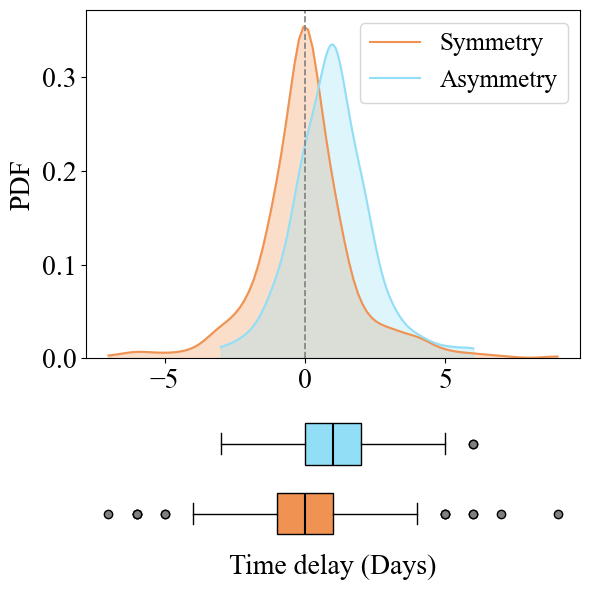

In [15]:
all_waiting_time1,latitude_label1,longitude_label1,latitude_label2,longitude_label2,distance = waiting_time(55,62.5,42.5,-82.5)#s
all_waiting_time2,latitude_label1,longitude_label1,latitude_label2,longitude_label2,distance = waiting_time(-5,-75,-7.5,-67.5)#as

#all_waiting_time2,latitude_label1,longitude_label1,latitude_label2,longitude_label2,distance = waiting_time(-40,72.5,-40,-30)#s
#all_waiting_time2,latitude_label1,longitude_label1,latitude_label2,longitude_label2,distance = waiting_time(22.5,-32.5,22.5,-40.0)#as

plt.rcParams['font.family'] = 'Times New Roman'

fig = plt.figure(figsize=(6,6))
gs = fig.add_gridspec(2, height_ratios=[2.5, 1])  # 设置高度比例

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

#----------------------------------------------------------------------------------------------------------

kde1 = gaussian_kde(all_waiting_time1)
x1 = np.linspace(min(all_waiting_time1), max(all_waiting_time1), 100)
kde_values1 = kde1(x1)

kde2 = gaussian_kde(all_waiting_time2)
x2 = np.linspace(min(all_waiting_time2), max(all_waiting_time2), 100)
kde_values2 = kde2(x2)

ax1.plot(x1, kde_values1, color='#F09252', label='Symmetry')
ax1.plot(x2, kde_values2, color='#92DEF6', label='Asymmetry')

ax1.fill_between(x1, kde_values1, color='#F09252', alpha=0.3)
ax1.fill_between(x2, kde_values2, color='#92DEF6', alpha=0.3)

ax1.set_ylim(bottom=0)

ax1.tick_params(axis='both', labelsize=20)
ax1.axvline(x=0, color='gray', linestyle='--',linewidth=1.2)
#ax1.set_xlim(-7,7) 
ax1.set_ylabel('PDF', fontsize=20)
ax1.legend(loc='upper right', fontsize=18)
#----------------------------------------------------------------------------------------------------------

data = [all_waiting_time1, all_waiting_time2]
boxprops = dict(edgecolor='black', linewidth=1)  # 设置 box 边框属性
medianprops = dict(color='black',linewidth=1.5)  # 设置中位线颜色
whiskerprops = dict(color='black',linewidth=1)  # 设置 whisker 颜色
capprops = dict(color='black',linewidth=1)  # 设置 cap 颜色
flierprops = dict(markerfacecolor='gray', marker='o')  # 设置离群点颜色

# 绘制 boxplot
boxplot = ax2.boxplot(data, vert=False, patch_artist=True, positions=[1, 2], widths=0.6,
                      boxprops=boxprops, medianprops=medianprops,
                      whiskerprops=whiskerprops, capprops=capprops,
                      flierprops=flierprops)

# 设置每个 box 的颜色
colors = ['#F09252', '#92DEF6']  # 定义颜色列表
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel(r'Time delay (Days)', fontsize=20)
ax2.tick_params(axis='both', labelsize=25)

for spine in ax2.spines.values():
    spine.set_visible(False)
ax2.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

plt.subplots_adjust(hspace=0.1)  # 调整此值来改变间距
plt.tight_layout()
plt.savefig("FIG/FIG1/FIG1d.svg", bbox_inches='tight', dpi=400, transparent=True)
#fig.savefig('../image/fig2b.svg',dpi = 750,bbox_inches='tight') 


# C

In [10]:

real_address = '../../data/Network1/EvSy_real.h5'

f_real = h5py.File(real_address,'r')
real_events = f_real['events'][:]
real_EvSy_all = f_real['EvSy_all'][:]
real_lat = f_real['lat'][:]
real_lon = f_real['lon'][:]
f_real.close()

threshold_address = '../../data/Each_SC_threshold_result/Network1_SC_threshold.h5'
f_threshold = h5py.File(threshold_address,'r')
threshold = f_threshold['SC_threshold'][()]
f_threshold.close()


#--------------------------------------------------------------------------------------------

real_SC_array = np.zeros((73,144,73,144))

for m in range (0,73,1):
    for n in range (0,144,1):
        for p in range (0,73,1):
            for q in range (0,144,1):

                real_SC_array[m,n,p,q] = real_EvSy_all[m,n,p,q]/math.sqrt(real_events[m,n]*real_events[p,q])

FT_SC_array = np.zeros((10,73,144,73,144))
for i in range (10):
    dataset_name = f'EvSy_FT_{i+1}.h5'
    FT_data_address = '../../data/Network1' + f'/NULL_MODEL/{dataset_name}'
    f_FT = h5py.File(FT_data_address,'r')
    FT_data_EvSy = f_FT['EvSy_all'][:]
    FT_data_events = f_FT['events'][:]
    f_FT.close()
    for m in range (0,73,1):
        for n in range (0,144,1):
            for p in range (0,73,1):
                for q in range (0,144,1):

                    FT_SC_array[i,m,n,p,q] = FT_data_EvSy[m,n,p,q]/math.sqrt(FT_data_events[m,n]*FT_data_events[p,q])

real_point_sum = np.reshape(real_SC_array,-1)
FT_point_sum = np.reshape(FT_SC_array,-1)
 

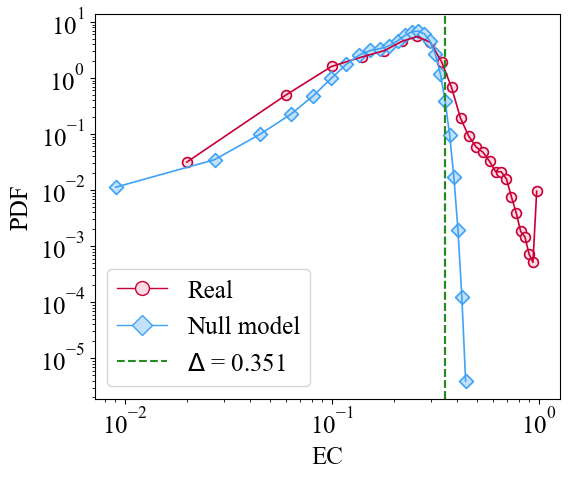

In [13]:
fig = plt.figure(figsize=(6,5))
plt.rcParams['font.family'] = 'Times New Roman'


d1 = plt.hist(real_point_sum,density=True,bins = 25,alpha=0,color='red')
d2 = plt.hist(FT_point_sum,density=True,bins = 25,alpha=0,color='blue')

d1y=d1[0]
d1x=d1[1][:-1]+(d1[1][1:]-d1[1][:-1])/2
d2y=d2[0]
d2x=d2[1][:-1]+(d2[1][1:]-d2[1][:-1])/2


plt.plot(d1x,d1y,c='#C80036',linewidth=1.2)
plt.plot(d2x,d2y,c='#3FA2F6',linewidth=1.2)

plt.scatter(d1x,d1y, c='#FEDAE3', edgecolors='#C80036',s=50,marker = 'o',linewidths=1.2)
plt.scatter(d2x,d2y, c='#C3E1F9', edgecolors='#3FA2F6',s=50,marker = 'D',linewidths=1.2)

plt.axvline(x=threshold, color='forestgreen',label= f'Threshold = {threshold:.3f}',linestyle='--',linewidth=1.5)

legend_elements = [
Line2D([0], [0], color='#C80036', lw=1, marker='o', markersize=10, label='Real',markerfacecolor='#FEDAE3', markeredgecolor='#C80036'), 
Line2D([0], [0], color='#3FA2F6', lw=1, marker='D', markersize=10, label='Null model',markerfacecolor='#C3E1F9', markeredgecolor='#3FA2F6'),
Line2D([0], [0], color='forestgreen',linestyle='--', lw=1.5 ,label=r'$\Delta$ = '+f'{threshold:.3f}')
]
plt.legend(handles=legend_elements,fontsize=18)
plt.axvline(x=threshold, color='forestgreen',label= f'Threshold = {threshold:.3f}',linestyle='--',linewidth=1.5)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='both', labelsize=18)
plt.xlabel('EC',fontsize=18)
plt.ylabel('PDF',fontsize=18)
plt.savefig("FIG/FIG1/FIG1c.svg", bbox_inches='tight', dpi=400, transparent=True)
plt.show()

#fig.savefig('../image/figS2e.svg',dpi = 750,bbox_inches='tight') 